# Import necessary packages and load dataset

In [2]:
#import neccesary packages
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
# import spacy
# import en_core_web_sm
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('data/justice.csv')

In [6]:
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


In [7]:
df.shape

(3303, 16)

### 5% missing rule

In [8]:
df.isna().sum()

Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

In [9]:
threshold = len(df) * 0.05
threshold

165.15

In [10]:
df.columns[(df.isna().sum() > 0) & (df.isna().sum() <= threshold)]

Index(['first_party', 'second_party', 'first_party_winner', 'decision_type',
       'disposition', 'issue_area'],
      dtype='object')

In [11]:
cols_to_drop = df.columns[(df.isna().sum() > 0) \
                               & (df.isna().sum() <= threshold)]

In [12]:
df.dropna(subset=cols_to_drop, inplace=True)
df.shape

(3098, 16)

In [13]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df.shape

(3098, 15)

## Wrangling

In [14]:
df.columns

Index(['ID', 'name', 'href', 'docket', 'term', 'first_party', 'second_party',
       'facts', 'facts_len', 'majority_vote', 'minority_vote',
       'first_party_winner', 'decision_type', 'disposition', 'issue_area'],
      dtype='object')

In [15]:
df.decision_type.value_counts()

majority opinion                     2723
per curiam                            211
plurality opinion                     145
equally divided                        12
dismissal - improvidently granted       3
dismissal - other                       2
dismissal - moot                        1
opinion of the court                    1
Name: decision_type, dtype: int64

In [16]:
df.disposition.value_counts()

reversed/remanded            1050
affirmed                      966
reversed                      562
vacated/remanded              416
reversed in-part/remanded      61
reversed in-part               19
none                           13
vacated                         6
vacated in-part/remanded        5
Name: disposition, dtype: int64

In [17]:
df_prep = df.copy()

In [18]:
df_prep.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [19]:
cols = ['decision_type', 'disposition']

# Encode labels of multiple columns at once
df_prep[cols] = df_prep[cols].apply(LabelEncoder().fit_transform)

df_prep.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,4,5,Civil Rights
2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,4,5,Due Process
3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,4,5,Civil Rights
4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,4,8,First Amendment
5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,4,2,First Amendment


In [20]:
df_prep.decision_type.value_counts()

4    2723
6     211
7     145
3      12
0       3
2       2
1       1
5       1
Name: decision_type, dtype: int64

In [21]:
df_prep.disposition.value_counts()

5    1050
0     966
2     562
8     416
4      61
3      19
1      13
6       6
7       5
Name: disposition, dtype: int64

In [38]:
df.shape

(3098, 15)

In [46]:
df[['facts', 'issue_area', 'first_party_winner']].loc[300, :]

facts                 <p>On March 1, 1976, an Illinois Circuit Court...
issue_area                                           Criminal Procedure
first_party_winner                                                 True
Name: 300, dtype: object

In [22]:
df_prep['issue_area'].value_counts()

Criminal Procedure      848
Civil Rights            561
Economic Activity       538
First Amendment         350
Judicial Power          308
Due Process             127
Federalism              125
Privacy                  69
Unions                   59
Federal Taxation         51
Attorneys                37
Miscellaneous            19
Private Action            4
Interstate Relations      2
Name: issue_area, dtype: int64

In [23]:
df_prep['issue_area'] = LabelEncoder().fit_transform(df_prep['issue_area'])
df_prep.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,4,5,1
2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,4,5,3
3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,4,5,1
4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,4,8,7
5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,4,2,7


In [24]:
df_prep['issue_area'].value_counts()

2     848
1     561
4     538
7     350
9     308
3     127
6     125
11     69
13     59
5      51
0      37
10     19
12      4
8       2
Name: issue_area, dtype: int64

In [25]:
df_prep.reset_index(inplace=True)

In [26]:
df_prep.drop(columns=['index'], inplace=True)
df_prep.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,4,5,1
1,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,4,5,3
2,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,4,5,1
3,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,4,8,7
4,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,4,2,7


# Text preprocessing

In [27]:
def remove_stops(text, stops):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove html tags
    text = re.sub(r'<[^<>]*>', '', text)
    
    words = text.split()
    
    # Remove stopwords
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = ' '.join(final)
    
    # Remove punctuation
    final = final.translate(str.maketrans('', '', string.punctuation + '’'))
    final = ''.join([i for i in final if not i.isdigit()])
    
    # Remove double whitespace
    while '  ' in final:
        final = final.replace('  ', ' ')
        
    return final

In [28]:
months = ['Januanry', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


for month in months:
    print(df[df['facts'].str.contains(month)]['facts'])

Series([], Name: facts, dtype: object)
5       <p>Ernest E. Mandel was a Belgian professional...
29      <p>In 1966, D.H. Overmyer Co. entered into a c...
121     <p>On January 3, 1957, Kenneth Donaldson was c...
164     <p>On February 18, 1974, three enrolled Couer ...
192     <p>J. W. Gamble was a prisoner in the Huntingt...
                              ...                        
3168    <p>In the words of the Ninth Circuit decision ...
3173    <p>Hamid Mohamed Ahmed Ali Rehaif was present ...
3176    <p>The US Department of Defense awarded petiti...
3248    <p>In 2006, Petitioner Manfredo M. Salinas app...
3287    <p>In February 2011, Sergio Ramirez went with ...
Name: facts, Length: 65, dtype: object
18      <p>On January 4, 1967, John J. Morrissey enter...
30      <p>On July 20, 1958, intruders beat an elderly...
68      <p>Carol Jo LaFleur was a teacher at Patrick H...
97      <p>On March 11, 1973, border patrol agents sto...
179     <p>On March 6, 1975, federal prosecutors ind

In [29]:
def clean_docs(docs, months):
    stops = stopwords.words('english')
    stops = stops + months
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.append(clean_doc)
    return final

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [31]:
cleaned_facts = clean_docs(df_prep['facts'], months)

In [32]:
len(df_prep)

3098

In [34]:
print(df_prep['facts'][0])

<p>Joan Stanley had three children with Peter Stanley.  The Stanleys never married, but lived together off and on for 18 years.  When Joan died, the State of Illinois took the children.  Under Illinois law, unwed fathers were presumed unfit parents regardless of their actual fitness and their children became wards of the state.  Peter appealed the decision, arguing that the Illinois law violated the Equal Protection Clause of the Fourteenth Amendment because unwed mothers were not deprived of their children without a showing that they were actually unfit parents.  The Illinois Supreme Court rejected Stanley’s Equal Protection claim, holding that his actual fitness as a parent was irrelevant because he and the children’s mother were unmarried.</p>



In [35]:
print(cleaned_facts[0])

Joan Stanley three children Peter Stanley The Stanleys never married lived together years When Joan died State Illinois took children Under Illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards state Peter appealed decision arguing Illinois law violated Equal Protection Clause Fourteenth Amendment unwed mothers deprived children without showing actually unfit parents The Illinois Supreme Court rejected Stanleys Equal Protection claim holding actual fitness parent irrelevant childrens mother unmarried


In [36]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out

In [33]:
lemmatized_facts = lemmatization(cleaned_facts)

In [34]:
print(df_prep['facts'][0])
print()
print(cleaned_facts[0])
print()
print(lemmatized_facts[0])

<p>Joan Stanley had three children with Peter Stanley.  The Stanleys never married, but lived together off and on for 18 years.  When Joan died, the State of Illinois took the children.  Under Illinois law, unwed fathers were presumed unfit parents regardless of their actual fitness and their children became wards of the state.  Peter appealed the decision, arguing that the Illinois law violated the Equal Protection Clause of the Fourteenth Amendment because unwed mothers were not deprived of their children without a showing that they were actually unfit parents.  The Illinois Supreme Court rejected Stanley’s Equal Protection claim, holding that his actual fitness as a parent was irrelevant because he and the children’s mother were unmarried.</p>


Joan Stanley three children Peter Stanley The Stanleys never married lived together years When Joan died State Illinois took children Under Illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards sta

In [35]:
# Code comes from the Tfidf docs online
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(
                    lowercase=True, # lowercase characters
                    max_features=50,
                    max_df=0.8,
                    min_df=5,
                    ngram_range=(1,3),
                    stop_words='english' # Get rid of stopwords the second time for assurance
                    )

In [36]:
vectors = vectorizer.fit_transform(lemmatized_facts)
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()

denselist

[[0.0,
  0.0,
  0.0,
  0.24922864006504486,
  0.0,
  0.2678995308575918,
  0.0,
  0.0,
  0.2641081099354733,
  0.0,
  0.0,
  0.0,
  0.3288463918505689,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2253561017685479,
  0.0,
  0.0,
  0.0,
  0.0,
  0.5982458592216924,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2505214527178125,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.28165268797578874,
  0.0,
  0.3707413755905017],
 [0.0,
  0.2066796126302744,
  0.0,
  0.21397639748378722,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.29318365018107756,
  0.0,
  0.14874438220724492,
  0.0,
  0.2549222105666447,
  0.0,
  0.2073704008118291,
  0.2148078001625767,
  0.6295384689868883,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.30025300922652304,
  0.0,
  0.3037574667649969,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2656063541935503,
  0.0,
  0.0,
  0.0,


From the **`denselist`** output, the words with numbers greater than 0 have more importance and are referred to as **key words**.

In [37]:
vectors.toarray()[0]

array([0.        , 0.        , 0.        , 0.24922864, 0.        ,
       0.26789953, 0.        , 0.        , 0.26410811, 0.        ,
       0.        , 0.        , 0.32884639, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2253561 , 0.        , 0.        ,
       0.        , 0.        , 0.59824586, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.25052145, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.28165269, 0.        , 0.37074138])

In [38]:
df_prep['first_party_winner'] = LabelEncoder().fit_transform(df_prep['first_party_winner'])
df_prep.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,1,4,5,1
1,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,1,4,5,3
2,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,1,4,5,1
3,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,1,4,8,7
4,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,1,4,2,7


In [39]:
df_prep['first_party_winner'].value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

In [40]:
# X = vectors.toarray()
X = vectors
y = df_prep['first_party_winner']

# Train/test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## RandomForestClassifier using only `facts`

[[  8 207]
 [ 21 384]]
              precision    recall  f1-score   support

           0       0.28      0.04      0.07       215
           1       0.65      0.95      0.77       405

    accuracy                           0.63       620
   macro avg       0.46      0.49      0.42       620
weighted avg       0.52      0.63      0.53       620

0.632258064516129


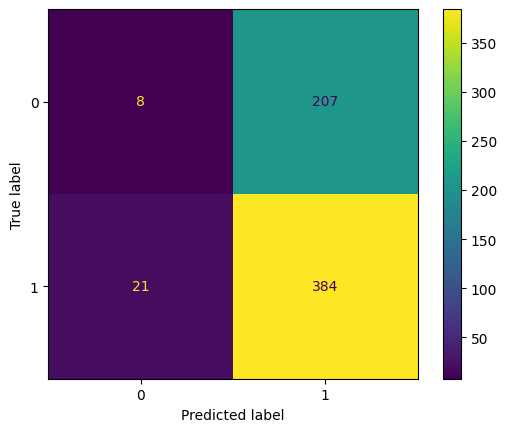

In [44]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot()
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

## XGB using only `facts`

[[ 40 175]
 [ 76 329]]
              precision    recall  f1-score   support

           0       0.34      0.19      0.24       215
           1       0.65      0.81      0.72       405

    accuracy                           0.60       620
   macro avg       0.50      0.50      0.48       620
weighted avg       0.55      0.60      0.56       620

0.5951612903225807


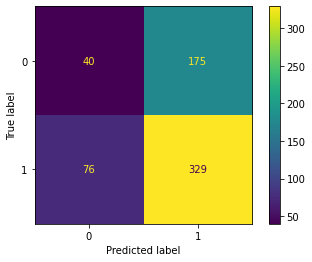

In [ ]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot()
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

## Using `disposition` and `decision_type`  features

In [ ]:
X = df_prep[["disposition", "decision_type"]]
y = df_prep['first_party_winner']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## RandomForestClassifier_X2

[[200  15]
 [  6 399]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       215
           1       0.96      0.99      0.97       405

    accuracy                           0.97       620
   macro avg       0.97      0.96      0.96       620
weighted avg       0.97      0.97      0.97       620

0.9661290322580646


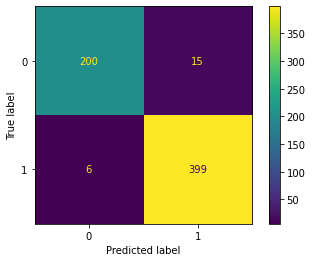

In [ ]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot()
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

## XGB_X2

[[201  14]
 [  5 400]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       215
           1       0.97      0.99      0.98       405

    accuracy                           0.97       620
   macro avg       0.97      0.96      0.97       620
weighted avg       0.97      0.97      0.97       620

0.9693548387096774


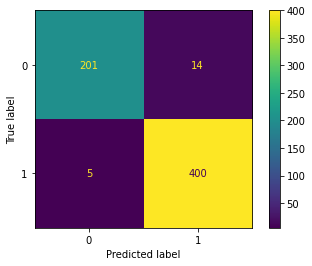

In [ ]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot()
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

## Using multiple features with `facts` feature

In [ ]:
tf_idf = pd.DataFrame(vectors.toarray())
tf_idf

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.230314,0.0,0.000000,0.246199,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.259767,0.000000,0.000000,0.342348
1,0.000000,0.0,0.152923,0.0,0.0,0.000000,0.158586,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.196851,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.393340,0.000000,0.000000,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.194524,0.000000,0.0,0.382018,0.000000,...,0.0,0.0,0.201333,0.000000,0.0,0.174677,0.000000,0.000000,0.234197,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.279366,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3094,0.000000,0.0,0.094401,0.0,0.0,0.000000,0.097897,0.0,0.145083,0.104649,...,0.0,0.0,0.152925,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.145518
3095,0.000000,0.0,0.120080,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.370203
3096,0.137014,0.0,0.076570,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.230912,0.000000,0.000000


In [ ]:
x_features = pd.merge(tf_idf,df_prep[["disposition", "decision_type"]],left_index=True, right_index=True)
x_features.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,disposition,decision_type
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.230314,0.0,0.000000,0.246199,...,0.000000,0.000000,0.0,0.000000,0.259767,0.0,0.000000,0.342348,5,4
1,0.0,0.0,0.152923,0.0,0.0,0.000000,0.158586,0.0,0.000000,0.000000,...,0.000000,0.196851,0.0,0.000000,0.000000,0.0,0.000000,0.000000,5,4
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,5,4
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.393340,0.0,0.000000,0.000000,8,4
4,0.0,0.0,0.000000,0.0,0.0,0.194524,0.000000,0.0,0.382018,0.000000,...,0.201333,0.000000,0.0,0.174677,0.000000,0.0,0.234197,0.000000,2,4


In [ ]:
X = x_features
y = df_prep['first_party_winner']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## RandomForestClassifier_X3

In [ ]:
# X_train.head()

In [ ]:
# X_train.columns

In [ ]:
# X_train.columns = X_train.columns.astype("str")

In [ ]:
# X_train.rename(columns = {'disposition': "100", 'decision_type':"101"}, inplace = True)
# # X_train.rename(columns = {"0": "facts"}, inplace = True)
# X_train.head()

#### Unknown `TypeError` with `RandomForestClassifier`

In [ ]:
# classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
# classifier.fit(X_train, y_train) 
# y_pred = classifier.predict(X_test)

# print(confusion_matrix(y_test,y_pred))
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
# disp.plot()
# print(classification_report(y_test,y_pred))
# print(accuracy_score(y_test, y_pred))

## XGB

[[200  15]
 [  5 400]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       215
           1       0.96      0.99      0.98       405

    accuracy                           0.97       620
   macro avg       0.97      0.96      0.96       620
weighted avg       0.97      0.97      0.97       620

0.967741935483871


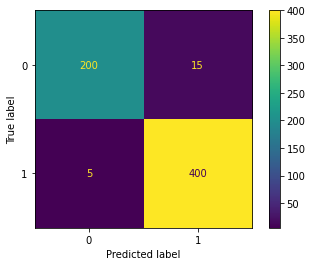

In [ ]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot()
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

## Tuning `RandomForestClassifier` with GridSearchCV

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,disposition,decision_type
326,0.10847,0.359443,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,...,0.0,0.078031,0.0,0.085197,0.070902,0.000000,0.114227,0.0,4,4
2041,0.00000,0.000000,0.000000,0.0,0.231711,0.0,0.000000,0.0,0.00000,0.000000,...,0.0,0.220237,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,4
2386,0.00000,0.000000,0.137818,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,...,0.0,0.177407,0.0,0.000000,0.000000,0.207809,0.259700,0.0,5,4
2082,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.170555,0.0,0.00000,0.182318,...,0.0,0.211708,0.0,0.000000,0.000000,0.000000,0.000000,0.0,8,4
411,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.12821,0.000000,...,0.0,0.214772,0.0,0.000000,0.097575,0.000000,0.000000,0.0,2,4


In [ ]:
X = df_prep[["disposition", "decision_type"]]
y = df_prep['first_party_winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# n_jobs=-1 to allow run it on all cores
params = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1,2,4,5],
    'min_samples_leaf': [1,2,4,5],
    'max_leaf_nodes': [4,10,20,50,None]
}

rand_gs = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
rand_gs.fit(X_train, y_train)

print('Best score:', rand_gs.best_score_)
print('Best score:', rand_gs.best_params_)

Best score: 0.9840893218585096
Best score: {'criterion': 'entropy', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


#### Evaluation

[[200  15]
 [  5 400]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       215
           1       0.96      0.99      0.98       405

    accuracy                           0.97       620
   macro avg       0.97      0.96      0.96       620
weighted avg       0.97      0.97      0.97       620

0.967741935483871


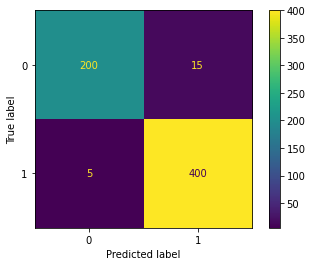

In [ ]:
y_pred = rand_gs.best_estimator_.predict(X_test)

print(confusion_matrix(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot()
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

## Tuning `XGB` with GridSearchCV

In [ ]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
#     'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

xgb_gs = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
xgb_gs.fit(X_train, y_train)

print('Best score:', xgb_gs.best_score_)
print('Best score:', xgb_gs.best_params_)


Best score: 0.9840020178581622
Best score: {'base_score': 0.2, 'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 5}


#### Evaluation

[[201  14]
 [  4 401]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       215
           1       0.97      0.99      0.98       405

    accuracy                           0.97       620
   macro avg       0.97      0.96      0.97       620
weighted avg       0.97      0.97      0.97       620

0.9709677419354839


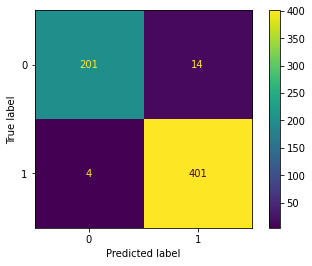

In [ ]:
y_pred = xgb_gs.best_estimator_.predict(X_test)

print(confusion_matrix(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot()
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

## Feature importance `RandomForestClassifier`

In [ ]:
# # Create a series containing feature importances from the model and feature names from the training data
# feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# # Plot a simple bar chart
# feature_importances.plot.bar();

## Feature importance `XGB`

In [ ]:
# # Create a series containing feature importances from the model and feature names from the training data
# feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# # Plot a simple bar chart
# feature_importances.plot.bar();

## Extracting new features from **`facts`** column

In [ ]:
# Number of Characters
def count_chars(text):
    return len(text)

# Number of words
def count_words(text):
    return len(text.split())
    
# Number of unique words
def count_unique_words(text):
    return len(set(text.split()))

# Number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

In [ ]:
df_prep['char_count'] = df_prep["facts"].apply(lambda x: count_chars(x))
df_prep['word_count'] = df_prep["facts"].apply(lambda x: count_words(x))
df_prep['sent_count'] = df_prep["facts"].apply(lambda x: count_sent(x))
df_prep['uniq_count'] = df_prep["facts"].apply(lambda x: count_unique_words(x))

In [ ]:
# nltk.download('punkt') ---> Necessary Dependency

In [ ]:
df_prep.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area,char_count,word_count,sent_count,uniq_count
0,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,1,4,5,1,757,116,6,81
1,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,1,4,5,3,495,77,5,57
2,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,1,4,5,1,378,59,3,44
3,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,1,4,8,7,305,41,2,33
4,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,1,4,2,7,2282,344,12,201


In [ ]:
X = df_prep[["decision_type", "disposition", "issue_area",
             "char_count", "word_count", "sent_count", "uniq_count"]]
y = df_prep["first_party_winner"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## RandomForestClassifier_4

[[201  14]
 [  5 400]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       215
           1       0.97      0.99      0.98       405

    accuracy                           0.97       620
   macro avg       0.97      0.96      0.97       620
weighted avg       0.97      0.97      0.97       620

0.9693548387096774


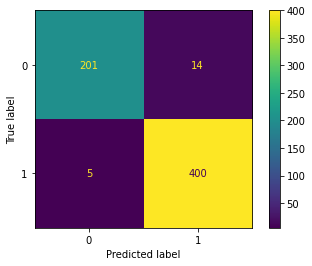

In [ ]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot()
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

## XGB_4

[[200  15]
 [  7 398]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       215
           1       0.96      0.98      0.97       405

    accuracy                           0.96       620
   macro avg       0.96      0.96      0.96       620
weighted avg       0.96      0.96      0.96       620

0.964516129032258


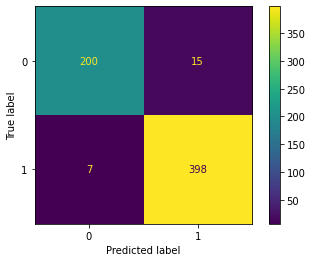

In [ ]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot()
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

### For clustering the docs

In [ ]:
all_keywords = []

for text in denselist:
    x = 0
    keywords = []
    for word in text:
        if word > 0:
            keywords.append(feature_names[x])
        x += 1
    all_keywords.append(keywords)

**`all_keywords`** is essentially a list of all the keywords in the **`facts`**.

In [ ]:
print(df_prep['facts'][0])
print()
print(all_keywords[0])

<p>Joan Stanley had three children with Peter Stanley.  The Stanleys never married, but lived together off and on for 18 years.  When Joan died, the State of Illinois took the children.  Under Illinois law, unwed fathers were presumed unfit parents regardless of their actual fitness and their children became wards of the state.  Peter appealed the decision, arguing that the Illinois law violated the Equal Protection Clause of the Fourteenth Amendment because unwed mothers were not deprived of their children without a showing that they were actually unfit parents.  The Illinois Supreme Court rejected Stanley’s Equal Protection claim, holding that his actual fitness as a parent was irrelevant because he and the children’s mother were unmarried.</p>


['appeal', 'argue', 'claim', 'decision', 'hold', 'law', 'reject', 'state', 'violate', 'year']


### Clustering with KMeans

In [ ]:
vectors[0].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.23031412, 0.        , 0.        , 0.24619935,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.24395306,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.30370436,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.21040742, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.55284365, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.38

In [ ]:
true_k = 5

model = KMeans(n_clusters=true_k,
               init='k-means++',
               max_iter=100,
               n_init=1)

In [ ]:
model.fit(vectors)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f914506e8b0>
Traceback (most recent call last):
  File "/home/izu/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/izu/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/izu/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/izu/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


KMeans(max_iter=100, n_clusters=5, n_init=1)

In [ ]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names_out()

In [ ]:
for i in range(true_k):
    print(f'Cluster {i}:')
    print('----------')
    for ind in order_centroids[i, :10]:
        print(terms[ind])
    print('\n')

Cluster 0:
----------
sentence
jury
trial
court
conviction
convict
death
murder
judge
guilty


Cluster 1:
----------
officer
police
search
arrest
evidence
trial
court
drug
right
motion


Cluster 2:
----------
court
district
district court
federal
hold
federal district
federal district court
appeal
claim
case


Cluster 3:
----------
state
claim
law
court
suit
file
action
federal
case
hold


Cluster 4:
----------
school
tax
employee
rule
plan
challenge
use
benefit
court
pay




# Neural Network

In [42]:
from tensorflow.keras.layers import (
    LSTM,
    Dropout,
    Bidirectional,
    Dense,
    Embedding,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Reshape,
    Input
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import (
    Precision,
    Recall,
    CategoricalAccuracy
)

# PCA Transformation

In [44]:
# df_decision = pd.get_dummies(df['decision_type'])
# df_disposition = pd.get_dummies(df['disposition'])
# df_cat = pd.concat([df_decision, df_disposition, df_prep[['first_party_winner']]], axis=1, join='inner')
# df_cat = pd.concat([df_cat, df_prep['first_party_winner']], axis=1, join='inner')
df_cat = df_prep[['first_party_winner']]

In [45]:
df_cat.head()

,first_party_winner
0,1
1,1
2,1
3,1
4,1


In [46]:
arr = vectors.toarray()

In [47]:
dataframe = pd.DataFrame(data=arr, columns=vectorizer.get_feature_names_out())

In [48]:
dataframe.head()

,action,affirm,allege,appeal,apply,argue,case,charge,claim,convict,...,sentence,state,statute,sue,suit,trial,use,violate,violation,year
0,0.0,0.00000,0.0,0.249229,0.000000,0.2679,0.0,0.0,0.264108,0.000000,...,0.0,0.250521,0.000000,0.0,0.0,0.000000,0.000000,0.281653,0.0,0.370741
1,0.0,0.20668,0.0,0.213976,0.000000,0.0000,0.0,0.0,0.000000,0.293184,...,0.0,0.000000,0.000000,0.0,0.0,0.265606,0.000000,0.000000,0.0,0.000000
2,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.476681,...,0.0,0.000000,0.549408,0.0,0.0,0.000000,0.000000,0.393161,0.0,0.000000
4,0.0,0.00000,0.0,0.000000,0.302744,0.0000,0.0,0.0,0.000000,0.000000,...,0.0,0.205648,0.323086,0.0,0.0,0.000000,0.277626,0.000000,0.0,0.000000


In [49]:
dataframe = pd.concat([dataframe, df_cat], axis=1, join='inner')
dataframe.head()

,action,affirm,allege,appeal,apply,argue,case,charge,claim,convict,...,state,statute,sue,suit,trial,use,violate,violation,year,first_party_winner
0,0.0,0.00000,0.0,0.249229,0.000000,0.2679,0.0,0.0,0.264108,0.000000,...,0.250521,0.000000,0.0,0.0,0.000000,0.000000,0.281653,0.0,0.370741,1
1,0.0,0.20668,0.0,0.213976,0.000000,0.0000,0.0,0.0,0.000000,0.293184,...,0.000000,0.000000,0.0,0.0,0.265606,0.000000,0.000000,0.0,0.000000,1
2,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1
3,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.476681,...,0.000000,0.549408,0.0,0.0,0.000000,0.000000,0.393161,0.0,0.000000,1
4,0.0,0.00000,0.0,0.000000,0.302744,0.0000,0.0,0.0,0.000000,0.000000,...,0.205648,0.323086,0.0,0.0,0.000000,0.277626,0.000000,0.0,0.000000,1


In [50]:
df_issue = pd.get_dummies(df['issue_area'])
dataframe = pd.concat([dataframe, df_issue], axis=1, join='inner')
dataframe.head()

,action,affirm,allege,appeal,apply,argue,case,charge,claim,convict,...,Economic Activity,Federal Taxation,Federalism,First Amendment,Interstate Relations,Judicial Power,Miscellaneous,Privacy,Private Action,Unions
1,0.0,0.20668,0.0,0.213976,0.000000,0.0,0.0,0.000000,0.0,0.293184,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.476681,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.00000,0.0,0.000000,0.302744,0.0,0.0,0.000000,0.0,0.000000,...,0,0,0,1,0,0,0,0,0,0
5,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.764437,0.0,0.370691,...,0,0,0,1,0,0,0,0,0,0


In [51]:
dataframe.shape

(2905, 65)

In [52]:
X = dataframe.drop(columns=['first_party_winner'])
y = dataframe['first_party_winner']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline 

pca = PCA(n_components=64)
pca_fit = pca.fit_transform(X_train)

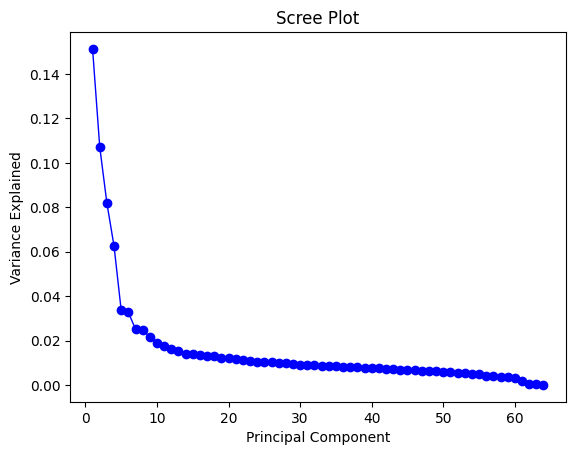

In [56]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [57]:
print(pca.explained_variance_ratio_.sum())

1.0


In [58]:
pca_fit.shape

(2324, 64)

In [59]:
pca_df = pd.DataFrame(data = pca_fit)
pca_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.250998,0.067515,0.796799,-0.467266,-0.042926,0.139884,-0.175543,-0.012255,0.289831,-0.242702,...,-0.104939,-0.018784,0.148844,-0.056006,-0.159379,-0.009268,0.039875,0.003506,-0.000702,6.142217e-15
1,0.769721,-0.041680,-0.098089,-0.060795,0.055770,0.133499,0.393819,-0.026714,0.228353,0.201833,...,0.015224,0.065258,0.017161,0.141603,0.063762,-0.077497,-0.039557,0.004152,0.001817,-5.752364e-15
2,-0.470502,-0.718395,-0.302866,-0.115423,0.003269,0.120091,0.312964,-0.027955,0.166157,0.086690,...,0.026656,-0.021660,-0.023830,0.007796,0.019747,-0.003200,-0.028645,0.005669,-0.002542,6.078063e-16


In [60]:
final_data = pd.concat([pca_df,y], axis=1, join='inner')

In [61]:
XX = final_data.drop(columns=['first_party_winner'])
YY = final_data[['first_party_winner']]

In [62]:
n_unique_words = 5000 # cut texts after this number of words
maxlen = 64
batch_size = 32

In [87]:
# model = Sequential()
# model.add(Embedding(n_unique_words, 128, input_length=maxlen))
# # model.add(Reshape((1, maxlen)))
# model.add(Reshape((64, 128), input_shape=(128,)))
# # model.add(Input(shape=(XX.shape[1], 1)))
# model.add(Bidirectional(LSTM(64)))
# model.add(Conv1D (32, 1, padding='same', activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='softmax'))
# model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [63]:
# model = Sequential()
# model.add(Embedding(n_unique_words, 128, input_length=maxlen))
# model.add(Bidirectional(LSTM(81, return_sequences=True)))  # Added 'return_sequences=True' to pass the sequence to the Conv1D layer
# model.add(Conv1D(32, 1, padding='same', activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [63]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [71]:
history=model.fit(XX, YY,
           batch_size=batch_size,
           epochs=150,
           validation_data=[X_test, y_test])

Epoch 1/150
70/70 [==============================] - 1s 12ms/step - loss: 0.6412 - accuracy: 0.6603 - val_loss: 0.6449 - val_accuracy: 0.6540
Epoch 2/150
70/70 [==============================] - 1s 10ms/step - loss: 0.6412 - accuracy: 0.6603 - val_loss: 0.6453 - val_accuracy: 0.6540
Epoch 3/150
70/70 [==============================] - 1s 9ms/step - loss: 0.6414 - accuracy: 0.6603 - val_loss: 0.6450 - val_accuracy: 0.6540
Epoch 4/150
70/70 [==============================] - 1s 11ms/step - loss: 0.6418 - accuracy: 0.6603 - val_loss: 0.6450 - val_accuracy: 0.6540
Epoch 5/150
70/70 [==============================] - 1s 9ms/step - loss: 0.6414 - accuracy: 0.6603 - val_loss: 0.6450 - val_accuracy: 0.6540
Epoch 6/150
70/70 [==============================] - 1s 11ms/step - loss: 0.6411 - accuracy: 0.6603 - val_loss: 0.6449 - val_accuracy: 0.6540
Epoch 7/150
70/70 [==============================] - 1s 14ms/step - loss: 0.6414 - accuracy: 0.6603 - val_loss: 0.6449 - val_accuracy: 0.6540
Epoch 8/

In [73]:
# model.evaluate()
court_case_judgement = model.evaluate(X_test, y_test, verbose=0)

In [74]:
court_case_judgement

[1.2338836193084717, 0.6540447473526001]

In [70]:
court_case_judgement[1] * 100

65.40447473526001

In [72]:
import joblib
import pickle

In [75]:
pickle.dump(model, open("model.pickle", "wb"))
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))

In [76]:
joblib.dump(model, open("model.joblib", "wb"))
joblib.dump(vectorizer, open("vectorizer.joblib", "wb"))